<a href="https://colab.research.google.com/github/mtomcanyi/Hackhealth2021-Challenge7/blob/main/ZCase_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
import pandas as pd

arrivalsDF = pd.read_csv('/content/drive/MyDrive/Hackhealth2021/Challenge7-zCase/ArrivalData/arrivals-clean.csv',
                         index_col=0,
                         parse_dates=["dispatchingTs","createdTs","closedTs","destinationApproval__requestTs","destinationApproval__responseTs"])
arrivalsDF.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (40,43,64,66,67,68,73) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(48863, 74)

## Timestmap parsing check
Check that difference in minutes between `createdTs` and `dispatchingTs` captured in `createdTs__minutes` still holds after we parsed into Python timestampts.

In [57]:
#arrivalsDF.iloc[:,39:43]
arrivalsDF.loc[:,["dispatchingTs","createdTs","closedTs","destinationApproval__requestTs","destinationApproval__responseTs"]]

,dispatchingTs,createdTs,closedTs,destinationApproval__requestTs,destinationApproval__responseTs
0,2020-08-31 15:33:45+00:00,2020-08-31 16:12:01.591000+00:00,2020-08-31 16:55:52.014000+00:00,2020-08-31 16:12:01.690000+00:00,2020-08-31 16:12:08.975000+00:00
1,2020-08-31 15:51:47+00:00,2020-08-31 16:12:28.315000+00:00,2020-08-31 17:47:04.386000+00:00,2020-08-31 16:12:28.399000+00:00,2020-08-31 16:12:37.591000+00:00
2,2020-08-31 16:01:25+00:00,2020-08-31 16:15:28.424000+00:00,2020-08-31 16:41:30.002000+00:00,2020-08-31 16:15:28.516000+00:00,NaT
3,2020-08-31 16:21:05+00:00,2020-08-31 16:59:30.841000+00:00,2020-08-31 18:10:40.979000+00:00,2020-08-31 16:59:30.937000+00:00,2020-08-31 17:00:16.401000+00:00
4,2020-08-31 16:31:04+00:00,2020-08-31 17:22:40.829000+00:00,2020-08-31 18:24:00.843000+00:00,2020-08-31 17:22:40.912000+00:00,NaT
...,...,...,...,...,...
48970,2021-11-16 12:57:21+00:00,2021-11-16 13:52:01.441000+00:00,NaT,NaT,NaT
48971,2021-11-16 13:55:16+00:00,2021-11-16 13:55:22.043000+00:00,NaT,NaT,NaT
48972,2021-11-16 13:48:29+00:00,2021-11-16 13:57:20.033000+00:00,NaT,NaT,NaT
48973,2021-11-16 13:55:05+00:00,2021-11-16 14:02:07.613000+00:00,NaT,NaT,NaT


In [ ]:
#arrivalsDF["MinDiff"] = (arrivalsDF["createdTs"] - arrivalsDF["dispatchingTs"]).dt.total_seconds()/60
#arrivalsDF[["MinDiff","createdTs__minutes"]]

##  How is the data set distributed regionally?

In [58]:
arrivalsDF["destination__hospitalName"].value_counts()

Oblastní nemocnice Kladno         10954
Nemocnice Havířov                  6311
Fakultní nemocnice Ostrava         5597
Nemocnice Motol                    5472
Nemocnice Na Bulovce               4589
Městská nemocice Ostrava           3918
Fakultní nemocnice Olomouc         3012
Fak. nemocnice Král. Vinohrady     2739
Všeob. fak. nemocnice v Praze      2739
IKEM                               1760
Nemocnice Na Homolce                998
Ostatní výjezdy STCPHA              382
Krajská nemocnice Liberec           202
Ostatní výjezdy MSK                 100
Ostatní výjezdy OLK                  23
Name: destination__hospitalName, dtype: int64

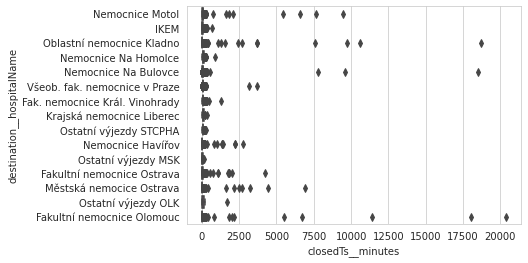

In [70]:
import seaborn as sns

sns.set_style("whitegrid")
sns.boxplot(y=arrivalsDF["destination__hospitalName"],x=arrivalsDF["closedTs__minutes"])

## How is the data set distributed in time?


In [65]:
arrivalsDF["createdTs__minutes"].describe()

count    48863.000000
mean        30.627612
std         18.202003
min        -54.000000
25%         21.000000
50%         29.000000
75%         39.000000
max        381.000000
Name: createdTs__minutes, dtype: float64

In [62]:
arrivalsDF[["destination__hospitalName","closedTs__minutes"]].groupby(by="destination__hospitalName").mean()

,closedTs__minutes
destination__hospitalName,
Fak. nemocnice Král. Vinohrady,78.609712
Fakultní nemocnice Olomouc,54.583721
Fakultní nemocnice Ostrava,42.127146
IKEM,50.427516
Krajská nemocnice Liberec,91.232673
Městská nemocice Ostrava,35.758682
Nemocnice Havířov,24.320919
Nemocnice Motol,65.959240
Nemocnice Na Bulovce,64.498366


In [60]:
arrivalsDP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48883 entries, 0 to 48974
Data columns (total 74 columns):
 #   Column                                                  Non-Null Count  Dtype              
---  ------                                                  --------------  -----              
 0   version                                                 48883 non-null  int64              
 1   lastStateEventSequence                                  48883 non-null  int64              
 2   lastTimelineEventSequence                               48883 non-null  int64              
 3   dispatchingAccountId                                    48883 non-null  object             
 4   dispatchingId                                           48883 non-null  object             
 5   dispatchingTs                                           48883 non-null  datetime64[ns, UTC]
 6   createdTs                                               48883 non-null  datetime64[ns, UTC]
 7   dispatchingNa

In [ ]:
arrivalsDF

,version,lastStateEventSequence,lastTimelineEventSequence,dispatchingAccountId,dispatchingId,dispatchingTs,createdTs,dispatchingName,destination__geoLocation,closedTs,resolution,attachments__count,media__count,ambulanceLocation__count,roomTeam__count,ambulanceLocation__geoPath,caseAddress__street,caseAddress__number,caseAddress__city,caseAddress__country,caseTeam__name,caseTeam__type,dispatchingTeam__name,destination__hospitalId,destination__wardId,destination__hospitalName,destination__wardName,ambulanceLocation__first__geoLocation,ambulanceLocation__first__dispatchingEtaTs,ambulanceLocation__first__locationTs,ambulanceLocation__last__geoLocation,ambulanceLocation__last__dispatchingEtaTs,ambulanceLocation__last__locationTs,patient__urgency,patient__classification,patient__comment,patient__firstName,patient__lastName,patient__sex,destinationApproval__status,destinationApproval__requestTs,destinationApproval__responseTs,destinationApproval__refusalReason,createdTs__minutes,closedTs__minutes,ambulanceLocation__first__dispatchingEtaTs__minutes,ambulanceLocation__first__locationTs__minutes,ambulanceLocation__last__dispatchingEtaTs__minutes,ambulanceLocation__last__locationTs__minutes,destinationApproval__requestTs__minutes,destinationApproval__responseTs__minutes,ambulanceLocation__last__dispatchingArrivalTs,ambulanceLocation__last__dispatchingArrivalTs__minutes,patient__birthDate,patient__birthYear,destination__dispatchingWardId,patient__age__value,patient__age,destination__dispatchingName,caseAddress__freeText,caseTeam__caseCode,caseTeam__ambulanceCode,destination__overriddenWardId,destination__dispatchingSpecialization,patient__naca__value,patient__naca__description,patient__diagnosis__value,patient__diagnosis__description,patient__bloodPressure__sys,patient__bloodPressure__dia,patient__spO2,patient__covid__value,patient__covid__description,patient__gcs__sum,MinDiff
0,157,71,8,dispatching:USZSSK,66A9A33F-A8E4-41E1-83A9-778D5423899D,2020-08-31 15:33:45+00:00,2020-08-31 16:12:01.591000+00:00,"ZZS Středočeského kraje, p.o.",POINT (14.3396786 50.0731031),2020-08-31 16:55:52.014000+00:00,ADMISSION,0,0,49,11,"LINESTRING (14.0630896164407 49.9476117924476,...",Ke Kosovu,33.0,Beroun,CZ,Beroun RZP,RZP,"Marušák Martin, Bc.",hospital:MOTOL,ward:MOTOL:OTHER,Nemocnice Motol,Motol - Ostatní,POINT (14.0630896164407 49.9476117924476),2020-08-31T16:35:22.839Z,2020-08-31T16:12:11.000Z,POINT (14.3399621152274 50.073666219246),2020-08-31T16:44:05.969Z,2020-08-31T16:37:41.000Z,N3,VERTIGO,Anonymized. Case dbe02241-e6f0-464e-a98c-46fbe...,Jarolím,Levý,M,GRANTED,2020-08-31 16:12:01.690000+00:00,2020-08-31 16:12:08.975000+00:00,NaN,38,44.0,23.0,0.0,6.0,26.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.276517
1,180,97,7,dispatching:USZSSK,55B444F8-36F3-42CD-B5E5-086CA8ADFE82,2020-08-31 15:51:47+00:00,2020-08-31 16:12:28.315000+00:00,"ZZS Středočeského kraje, p.o.",POINT (14.4575 50.0275),2020-08-31 17:47:04.386000+00:00,ADMISSION,0,0,84,10,"LINESTRING (15.1388673476618 49.6534466972465,...",Zahradní,203.0,Dolní Kralovice,CZ,Vlašim RZP 1,RZP,"Marušák Martin, Bc.",hospital:IKEM,ward:IKEM:KONTAKT,IKEM,IKEM Kontaktní místo,POINT (15.1388673476618 49.6534466972465),2020-08-31T17:08:25.045Z,2020-08-31T16:12:43.000Z,POINT (14.6792367197954 49.7870240030342),NaN,2020-08-31T17:05:55.000Z,N3,ÚRAZ,Anonymized. Case 425901a7-9d32-4daf-ad5b-e3990...,Ulrika,Fišrová,F,GRANTED,2020-08-31 16:12:28.399000+00:00,2020-08-31 16:12:37.591000+00:00,NaN,21,95.0,56.0,0.0,NaN,53.0,0.0,0.0,2020-08-31T17:05:51.000Z,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.688583
2,115,44,5,dispatching:USZSSK,0A190D51-6EED-4C82-AB12-CC79E15DC165,2020-08-31 16:01:25+00:00,2020-08-31 16:15:28.424000+00:00,"ZZS Středočeského kraje, p.o.",POINT (14.0855777 50.1412521),2020-08-31 16:41:30.002000+00:00,ADMISSION,0,0,29,9,"LINESTRING (13.9566977811097 50.1520953904137,...",U stadionu,374.0,Stochov,C